Import

In [ ]:
!pip install SpeechRecognition  # библиотека с популярными сервисами распознавания речи
!pip install jiwer              # модуль метрики качества в распознавании речи
!pip install ffmpeg-python      # библиотека для записи с микрофона
import speech_recognition as sR # библиотека распознавания речи
from matplotlib import pyplot as plt
from IPython.display import HTML, Audio 
from google.colab.output import eval_js 
from scipy.io.wavfile import read as wav_read
from base64 import b64decode
from jiwer import wer 
from PIL import Image
import numpy as np 
import ffmpeg
import scipy
import io
import os
%matplotlib inline

In [ ]:
# Подгружаем картинку c ПК
from google.colab import files
files.upload()

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Автомобиль

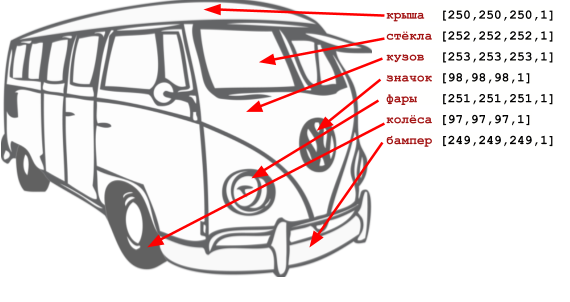

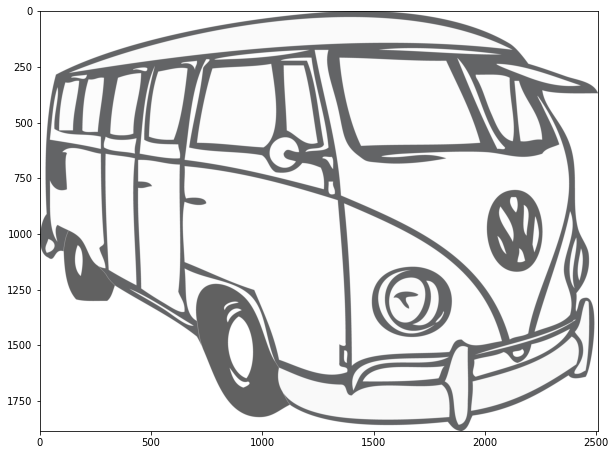

In [ ]:
# Создаем словарь частей машины с цветами пикселей
slovar = {'кузов' :253,
          'стёкла':252,
          'стекла':252,
          'фары'  :251,
          'крыша' :250,
          'бампер':249,
          'значок':98,
          'колеса':97,
          'колёса':97}

# Создаем словарь цветов в формате png
colors = {'жёлтый' :[255, 255, 0, 255],
          'желтый' :[255, 255, 0, 255],
          'красный':[255, 0, 0, 255],
          'синий'  :[0, 0, 255, 255],
          'зелёный':[0, 255, 0, 255],
          'зеленый':[0, 255, 0, 255],
          'голубой':[170, 170, 255, 255],
          'черный' :[0, 0, 0, 255],
          'чёрный' :[0, 0, 0, 255],
          'оранжевый':[255, 100, 0, 255]}

# Преобразуем картинку в массив Numpy
im = Image.open("/content/drive/MyDrive/Аутсорс раскраска/klipartz_last.png")
samosval = np.array(im)

# Выведем картинку на экран
plt.figure(figsize=(10,18))
plt.imshow(im)
plt.show()

Результат распознавания: крыша синий кузов жёлтые колёса чёрный бампер красный


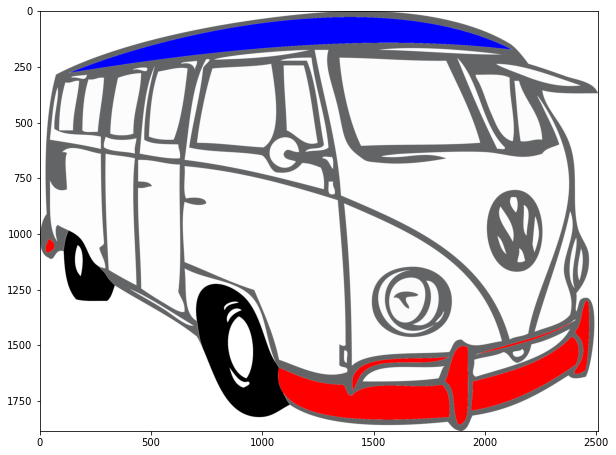

In [ ]:
#@title Запустите ячейку для начала записи команд

# Функция для изменения цвета, в соответствии с распознанными командами
def avto(arr):
  for ind,k in enumerate(arr):
    if k in slovar.keys():               
      if arr[ind+1] in colors.keys():
        samosval[samosval[:,:,0] == slovar[k]] = colors[arr[ind+1]]
  return samosval

# Функция распознавания речи с помощью speech_recognition
def recognizeAudio(filename, duration=None):
  AUDIO_FILE = os.path.join(filename) 
  r = sR.Recognizer()                 
  with sR.AudioFile(AUDIO_FILE) as source:
    audio = r.record(source, duration=duration)   
  return r.recognize_google(audio, language='ru')

# Функция для записи с микрофона из Python
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  riff_chunk_size = len(output) - 8
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)
  riff = output[:4] + bytes(b) + output[8:]
  sr, audio = wav_read(io.BytesIO(riff))
  return audio, sr

# Скрипт html для записи речи
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

# Запись голоса
audio, sr = get_audio()
scipy.io.wavfile.write('recording.wav', sr, audio)

# Распознование голосовых команд
res = recognizeAudio('recording.wav')

# Результат распознавания
print('Результат распознавания:', res)

# Преобразуем команды
samosval = np.array(im)
res2 = res.split(' ')

# Раскрашиваем
samosval = avto(res2)

# Выводим на экран
im2 = Image.fromarray(samosval)
plt.figure(figsize=(10,18))
plt.imshow(im2)
plt.show()

## Железный человек

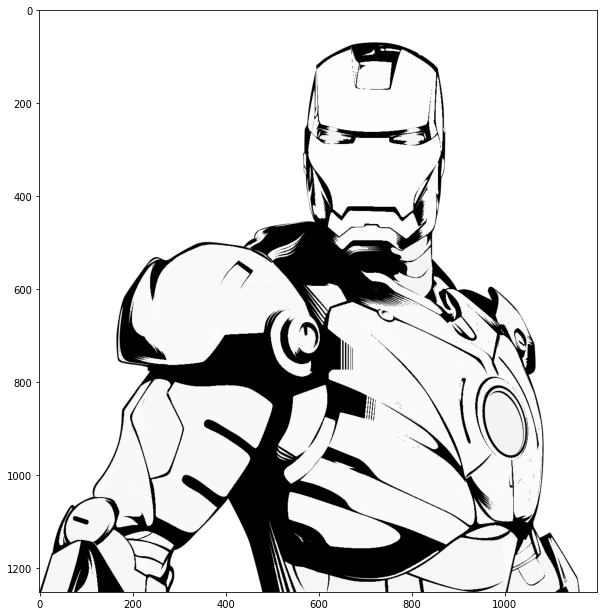

In [ ]:
# Создаем словарь частей железного человека с цветами пикселей
slovar2 = {'лицо'      :253, 
           'голова'    :252,
           'блики'     :251,
           'грудь'     :250,
           'плечи'     :249,
           'руки'      :248,
           'предплечье':247,
           'предплечья':247,
           'живот'     :246,
           'шея'       :245,
           'глаза'     :244,
           'реактор'   :243,
           'Reactor'   :243,
           }

# Создаем словарь цветов в формате png
colors2 = {'жёлтый' :[255, 255, 0, 255],
           'Жёлтый' :[255, 255, 0, 255],
           'красный':[255, 0, 0, 255],
           'синий'  :[0, 0, 255, 255],
           'зелёный':[0, 255, 0, 255],
           'голубой':[170, 170, 255, 255],
           'черный' :[0, 0, 0, 255],
           'чёрный' :[0, 0, 0, 255]}

# Преобразуем картинку в массив Numpy
im = Image.open("/content/drive/MyDrive/Аутсорс раскраска/ironman.png")
iron = np.array(im)

# Выведем картинку на экран
plt.figure(figsize=(10,18))
plt.imshow(im)
plt.show()

Результат распознавания: лицо Жёлтый голова чёрный грудь чёрный реактор жёлтый плечи чёрный руки красный предплечья чёрный шея чёрный


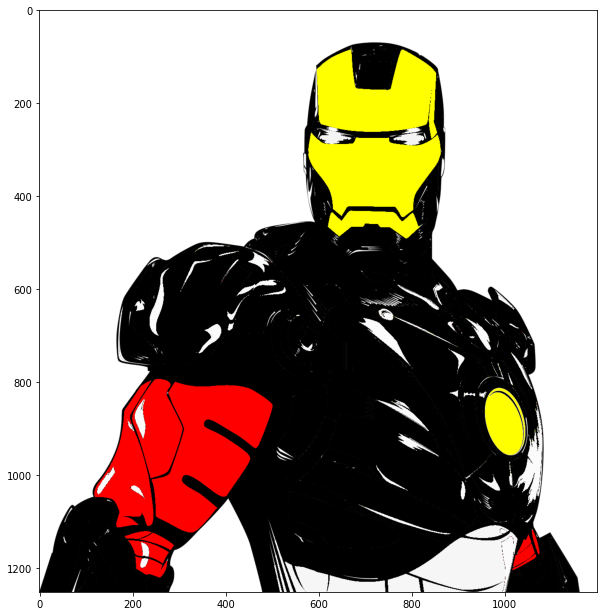

In [ ]:
#@title Запустите ячейку для начала записи команд

# Функция для изменения цвета, в соответствии с распознанными командами
def avto(arr):
  for ind,k in enumerate(arr):
    if k in slovar2.keys():
      if arr[ind+1] in colors2.keys():
        iron[iron[:,:,0] == slovar2[k]] = colors2[arr[ind+1]]
  return iron

# Функция распознавания речи с помощью speech_recognition
def recognizeAudio(filename, duration=None):
  AUDIO_FILE = os.path.join(filename) # задаем путь к аудиофайлу
  r = sR.Recognizer()                 # создаем объект класса Recognizer
  with sR.AudioFile(AUDIO_FILE) as source:
    audio = r.record(source, duration=duration)   # считываем аудиофайл
  return r.recognize_google(audio, language='ru') # запускаем распознавание

# Функция для записи с микрофона из Python
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  riff_chunk_size = len(output) - 8
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)
  riff = output[:4] + bytes(b) + output[8:]
  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

# Скрипт html для записи речи
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

# Запись голоса
audio, sr = get_audio()
scipy.io.wavfile.write('recording.wav', sr, audio)

# Распознование голосовых команд
res = recognizeAudio('recording.wav')

# Результат распознавания
print('Результат распознавания:', res)

# Преобразуем команды
iron = np.array(im)
res2 = res.split(' ')

# Раскрашиваем
iron = avto(res2)

# Выведем картинку на экран
im2 = Image.fromarray(iron)
plt.figure(figsize=(10,18))
plt.imshow(im2)
plt.show()